<a href="https://colab.research.google.com/github/Toan02Ky-UIT/CodeProject/blob/main/model_efficientnet_b3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [4]:
data_dir_model = '/gdrive/MyDrive/Project/Bai5/Model02'

In [ ]:
import os
import glob
import shutil
from sklearn.model_selection import train_test_split

# Define the data directory where your cloned repositories are located
data_dir_github = '/gdrive/MyDrive/Project/Bai5/Github' # Use a different name for the source directory

# Define the target directories for train and validation data
data_dir_model = '/gdrive/MyDrive/Project/Bai5/Model02' # Use a different name for the destination directory
train_dir = os.path.join(data_dir_model, 'train')
val_dir = os.path.join(data_dir_model, 'val')

# Get all image file paths
a = glob.glob(f'{data_dir_github}/*/hand_written_digit/??52????')
print(a)
image_lists = []
for folder in a:
  for num in range(10):
    t = glob.glob(f'{folder}/{num}_*')
    image_lists += t

# Create a list of (filepath, label) tuples from image_lists
image_data_with_labels = []
for filepath in image_lists:
    # Extract the label (the first digit in the filename)
    filename = os.path.basename(filepath)
    label = filename.split('_')[0]
    image_data_with_labels.append((filepath, label))

# Split the data (which is now a list of tuples) into training and validation sets
train_data, val_data = train_test_split(image_data_with_labels, test_size=0.2, random_state=42)

# Create the target directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for digit in range(10):
    os.makedirs(os.path.join(train_dir, str(digit)), exist_ok=True)
    os.makedirs(os.path.join(val_dir, str(digit)), exist_ok=True)

# Copy the image files to the new directory structure
# train_data and val_data now contain tuples (filepath, label)
print("Copying training images...")
for filepath, label in train_data:
    destination_path = os.path.join(train_dir, label, os.path.basename(filepath))
    shutil.copy(filepath, destination_path)

print("Copying validation images...")
for filepath, label in val_data:
    # Construct the destination path in the new val directory
    destination_path = os.path.join(val_dir, label, os.path.basename(filepath))
    shutil.copy(filepath, destination_path)

print("Data splitting and copying complete.")

KeyboardInterrupt: 

In [5]:
#Albumentations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=5),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
        transforms.RandomPerspective(distortion_scale=0.05, p=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir_model, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


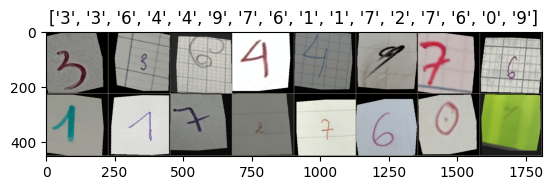

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

for param in model_ft.parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=1e-4, weight_decay=1e-4)

exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=25)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:01<00:00, 40.8MB/s]


In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5402 Acc: 0.4193
val Loss: 0.6319 Acc: 0.8127

Epoch 1/24
----------
train Loss: 0.5178 Acc: 0.8294
val Loss: 0.2919 Acc: 0.9090

Epoch 2/24
----------
train Loss: 0.2984 Acc: 0.9059
val Loss: 0.2136 Acc: 0.9295

Epoch 3/24
----------
train Loss: 0.2098 Acc: 0.9323
val Loss: 0.1551 Acc: 0.9527

Epoch 4/24
----------
train Loss: 0.1456 Acc: 0.9554
val Loss: 0.1303 Acc: 0.9581

Epoch 5/24
----------
train Loss: 0.1104 Acc: 0.9676
val Loss: 0.1196 Acc: 0.9661

Epoch 6/24
----------
train Loss: 0.0880 Acc: 0.9746
val Loss: 0.1446 Acc: 0.9590

Epoch 7/24
----------
train Loss: 0.0708 Acc: 0.9803
val Loss: 0.1244 Acc: 0.9652

Epoch 8/24
----------
train Loss: 0.0584 Acc: 0.9863
val Loss: 0.3955 Acc: 0.9679

Epoch 9/24
----------
train Loss: 0.0705 Acc: 0.9769
val Loss: 0.1041 Acc: 0.9697

Epoch 10/24
----------
train Loss: 0.0505 Acc: 0.9852
val Loss: 0.1005 Acc: 0.9715

Epoch 11/24
----------
train Loss: 0.0452 Acc: 0.9881
val Loss: 0.0991 Acc: 0.9715

Ep

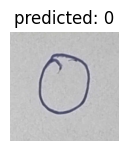

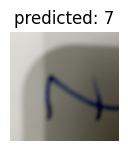

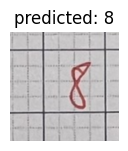

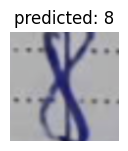

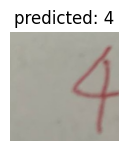

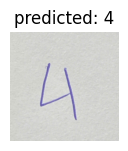

In [13]:
visualize_model(model_ft)

In [14]:
predict_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
!pip install pillow_heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.3 MB/s eta 0:00:00


In [16]:
extract_dir = '/gdrive/MyDrive/Project/Bai5/Model02'
from torch.utils.data import Dataset, DataLoader
from pillow_heif import register_heif_opener
from PIL import Image, UnidentifiedImageError # Import Image as well
import os

# Register the HEIF opener before initializing the dataset
register_heif_opener()

class PredictDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.heic', '.jfif']
        self.image_files = []
        for f in os.listdir(root_dir):
            filepath = os.path.join(root_dir, f)
            if os.path.isfile(filepath) and os.path.splitext(f)[1].lower() in image_extensions:
                try:
                    # Attempt to open the image to check if it's valid
                    img = Image.open(filepath)
                    img.verify() # Verify that it is an image
                    self.image_files.append(f)
                except (IOError, UnidentifiedImageError) as e:
                    print(f"Warning: Could not identify or open image file {filepath}. Skipping. Error: {e}")
                finally:
                    if 'img' in locals() and img:
                        img.close() # Close the image file after verification

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB') # Đảm bảo ảnh có 3 kênh màu
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

# Tạo Dataset và DataLoader
predict_dataset = PredictDataset(extract_dir, transform=predict_transforms)
predict_dataloader = DataLoader(predict_dataset, batch_size=16, shuffle=False, num_workers=2)

# Đặt mô hình về chế độ đánh giá
model_ft.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
import csv
csv_output_path = '/gdrive/MyDrive/Project/Bai5/Model02/predictions.csv' # Đường dẫn đến file CSV đầu ra
# Dự đoán và lưu kết quả vào file CSV
with open(csv_output_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    # Ghi hàng tiêu đề
    csv_writer.writerow(['file_name', 'predicted_class'])

    with torch.no_grad():
        for inputs, filenames in predict_dataloader:
            # Bỏ qua các batch có chứa ảnh bị lỗi (trả về None)
            if inputs is None or filenames is None:
                continue

            inputs = inputs.to(device)

            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                filename = filenames[i]
                predicted_class_index = preds[i].item()
                predicted_class_name = class_names[predicted_class_index]
                csv_writer.writerow([filename, predicted_class_name])